In this notebook we aim to find the learning modes of a trained neural network through the tangent kernel.

In [1]:
import torch
import torch.nn as nn
from torch.func import vmap, jacrev, functional_call
from torch.optim import SGD
from torch import reshape
from torch.linalg import eig

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

We use a ReLU network with three hidden layers, each with $128$ hidden units. We use this network for a binary classification problem. The dataset consists of $2D$ points in the $[-1,1]^2$. Points within a circle of radius $(\frac{2}{\pi})^{\frac{1}{4}}$ centered at the origin define one class, and points outside this region form another class.

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(2):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

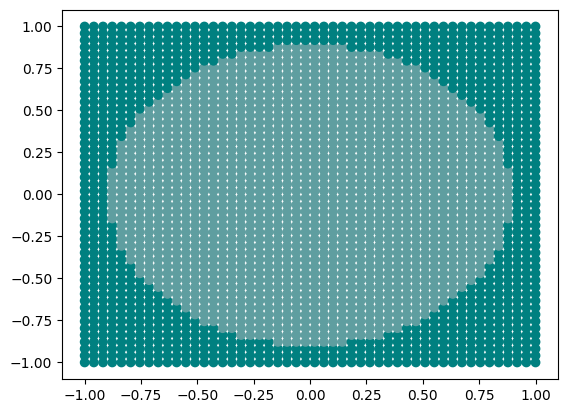

In [3]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if x[0]**2+x[1]**2<np.sqrt(2/np.pi) else 0
y=np.array([encode_inputs(x) for x in X])

(trainX, testX, trainY, testY) = train_test_split(X, y,test_size=0.15, random_state=95)
X = torch.from_numpy(X).float()
trainX = torch.from_numpy(trainX).float()
testX = torch.from_numpy(testX).float()
trainY = torch.from_numpy(trainY).float()
testY = torch.from_numpy(testY).float()

colors=np.full(len(y), 'cadetblue')
colors[y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [4]:
model = NeuralNet(2,128,2)
ReLU_glorot_init(model)

def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

BATCH_SIZE = 100
EPOCHS = 200
LR = 0.05

opt = SGD(model.parameters(), lr=LR)
lossFunc = nn.CrossEntropyLoss()

def ReLU_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(0, np.sqrt(2/len(param)))
    
ReLU_init(model)

def training():
	opt = SGD(model.parameters(), lr=LR)
	trainAcc = 0
	samples_train = 0
	model.train()
	for (batchX, batchY) in next_batch(trainX, trainY, BATCH_SIZE):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainAcc += (predictions.max(1)[1] == batchY).sum().item()
		samples_train += batchY.size(0)
	
	testAcc = 0
	samples_test = 0
	model.eval()
	with torch.no_grad():
		for (batchX, batchY) in next_batch(testX, testY, BATCH_SIZE):
			(batchX, batchY) = (batchX, batchY)
			predictions = model(batchX)
			loss = lossFunc(predictions, batchY.long())
			testAcc += (predictions.max(1)[1] == batchY).sum().item()
			samples_test += batchY.size(0)

	return trainAcc/samples_train, testAcc / samples_test

for n in range(EPOCHS):
    train_a,test_a=training()
    print('Epoch {}: Training Accuracy {:.3f}, Testing Accuracy: {:.3f}'.format(n+1,train_a,test_a))

Epoch 1: Training Accuracy 0.731, Testing Accuracy: 0.779
Epoch 2: Training Accuracy 0.828, Testing Accuracy: 0.752
Epoch 3: Training Accuracy 0.877, Testing Accuracy: 0.792
Epoch 4: Training Accuracy 0.896, Testing Accuracy: 0.811
Epoch 5: Training Accuracy 0.906, Testing Accuracy: 0.829
Epoch 6: Training Accuracy 0.913, Testing Accuracy: 0.853
Epoch 7: Training Accuracy 0.921, Testing Accuracy: 0.872
Epoch 8: Training Accuracy 0.927, Testing Accuracy: 0.885
Epoch 9: Training Accuracy 0.935, Testing Accuracy: 0.888
Epoch 10: Training Accuracy 0.940, Testing Accuracy: 0.896
Epoch 11: Training Accuracy 0.945, Testing Accuracy: 0.901
Epoch 12: Training Accuracy 0.946, Testing Accuracy: 0.909
Epoch 13: Training Accuracy 0.950, Testing Accuracy: 0.915
Epoch 14: Training Accuracy 0.954, Testing Accuracy: 0.917
Epoch 15: Training Accuracy 0.956, Testing Accuracy: 0.920
Epoch 16: Training Accuracy 0.959, Testing Accuracy: 0.920
Epoch 17: Training Accuracy 0.960, Testing Accuracy: 0.920
Epoch 

In [5]:
params=dict(model.named_parameters())

def empirical_ntk_jacobian_contraction(params, x1, x2, compute='full'):
    # Compute J(x1)
    jac1 = vmap(jacrev(functional_call, argnums=1),(None,None, 0))(model, params, x1)
    jac1 = [j.flatten(2) for j in jac1.values()]
    
    # Compute J(x2)
    jac2 = vmap(jacrev(functional_call, argnums=1),(None,None, 0))(model, params, x2)
    jac2 = [j.flatten(2) for j in jac2.values()]
    
    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False
        
    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

result = empirical_ntk_jacobian_contraction(params, X, X, 'trace')

Plotting the eigenvectors of the tangent kernel on our grid we can see that the features learned by the network include the boundary of the circle, which is to be expected as we have trained it to classify points that lie on either side of this boundary.

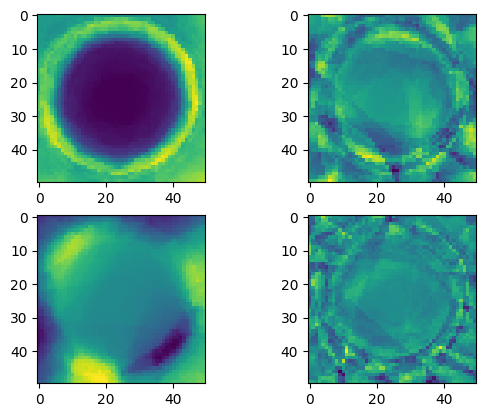

In [6]:
fig, axs = plt.subplots(2,2)

vector_ind=[0,10,50,100]
e_vectors=eig(result)[1][:,vector_ind]

axs[0,0].imshow(np.real(reshape(e_vectors[:,0],(RES,RES)).detach().numpy()))
axs[1,0].imshow(np.real(reshape(e_vectors[:,1],(RES,RES)).detach().numpy()))
axs[0,1].imshow(np.real(reshape(e_vectors[:,2],(RES,RES)).detach().numpy()))
axs[1,1].imshow(np.real(reshape(e_vectors[:,3],(RES,RES)).detach().numpy()))